In [1]:
import os 
import matplotlib
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt

In [64]:
# Folder path containing the CSV files
folder_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data'
file_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv'
plt.rcParams['figure.figsize'] = (20, 8)

In [4]:
def read_single_file(file_path):
    df = pd.read_csv(file_path)
    return df
    
    # select by activity and plot them
    

single_df = read_single_file(file_path)

In [5]:
def read_all_data(folder_path):
    # List to store the DataFrames
    data_frames = []
    for filename in os.listdir(folder_path):
        
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path,filename)
            df = pd.read_csv(file_path)
            data_frames.append(df)
        else:
            print(f"{filename} is not a csv file")
        
    return data_frames 
    # print(df.head(5))


data_frames = read_all_data(folder_path)
combined_df = pd.concat(data_frames)




index.html is not a csv file


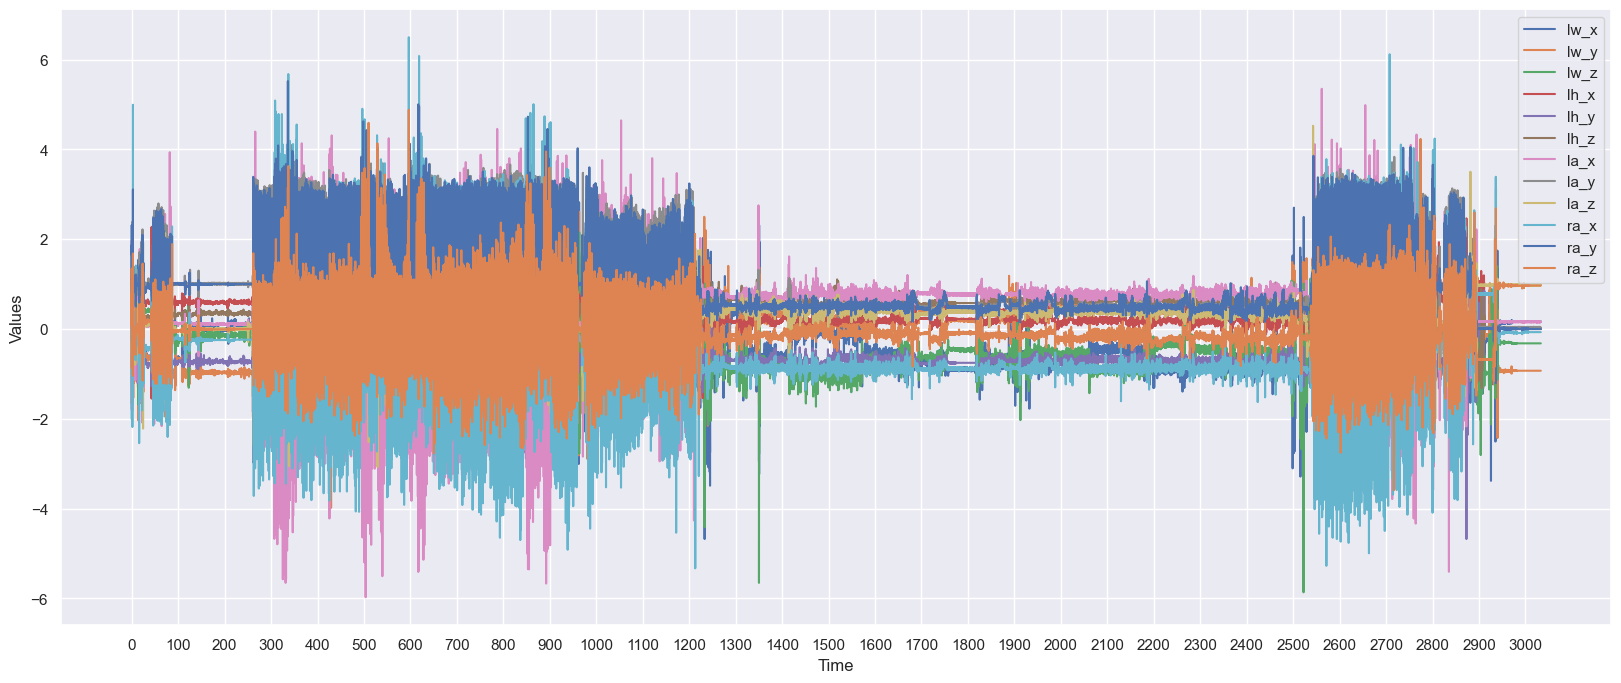

In [57]:
def plot_all(df):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    variables = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    df.plot(x='time_s', y=variables)
    tick_positions = range(0, 3034, 100) 
    plt.xticks(tick_positions)
    # Adding labels and a legend
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(variables)
    
    # Displaying the plot
    plt.show()
# plot(combined_df)
plot_all(single_df)


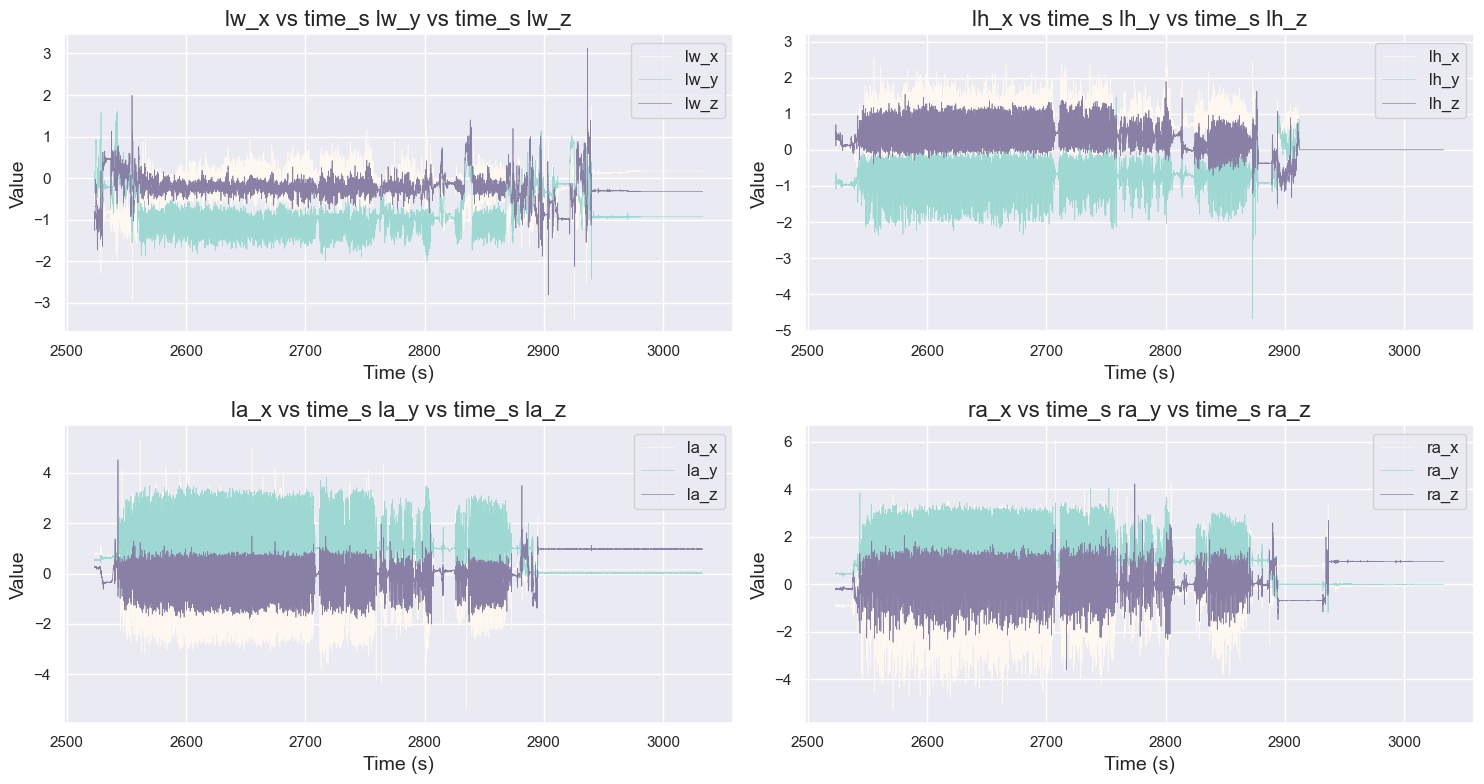

In [90]:


# colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
colors = ["#FFF8F0","#9DD9D2","#8981A5"]
# assuming single_df is your DataFrame
df_99 = single_df[single_df['activity'] == 99]
df_99 = df_99[df_99['time_s'] >= 2500]

# create larger subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# Plotting
for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
    for variable, color in zip(variables, colors):
        sns.lineplot(data=df_99, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
    
    ax.legend(loc='upper right', fontsize=12)
    ax.set_title(' vs time_s '.join(variables), fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [86]:
def make_x_y_z_plot(df):
    # colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
    colors = ["#FFF8F0","#9DD9D2","#8981A5"]
    # create larger subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        # Plotting
    for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
        for variable, color in zip(variables, colors):
            sns.lineplot(data=df, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(' vs time_s '.join(variables), fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Value', fontsize=14)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    

In [87]:
# show the period of each activity
def show_x_y_z_plot(df,activity):
    if activity == 99:
        df_99 = df[df['activity'] == 99]
        make_x_y_z_plot(df_99)
    elif activity == 77:
        df_77 = df[df['activity'] == 77]
        make_x_y_z_plot(df_77)
    elif activity ==4:
        df_4 = df[df['activity'] == 4]
        make_x_y_z_plot(df_4)
    elif activity ==3:
        df_3 = df[df['activity'] == 3]
        make_x_y_z_plot(df_3)
    elif activity ==2:
        df_2 = df[df['activity'] == 2]
        make_x_y_z_plot(df_2)
    elif activity ==1:
        df_1 = df[df['activity'] == 1]
        make_x_y_z_plot(df_1)




<built-in method values of dict object at 0x327872680>
Now activity is non-study activity and the code is 99


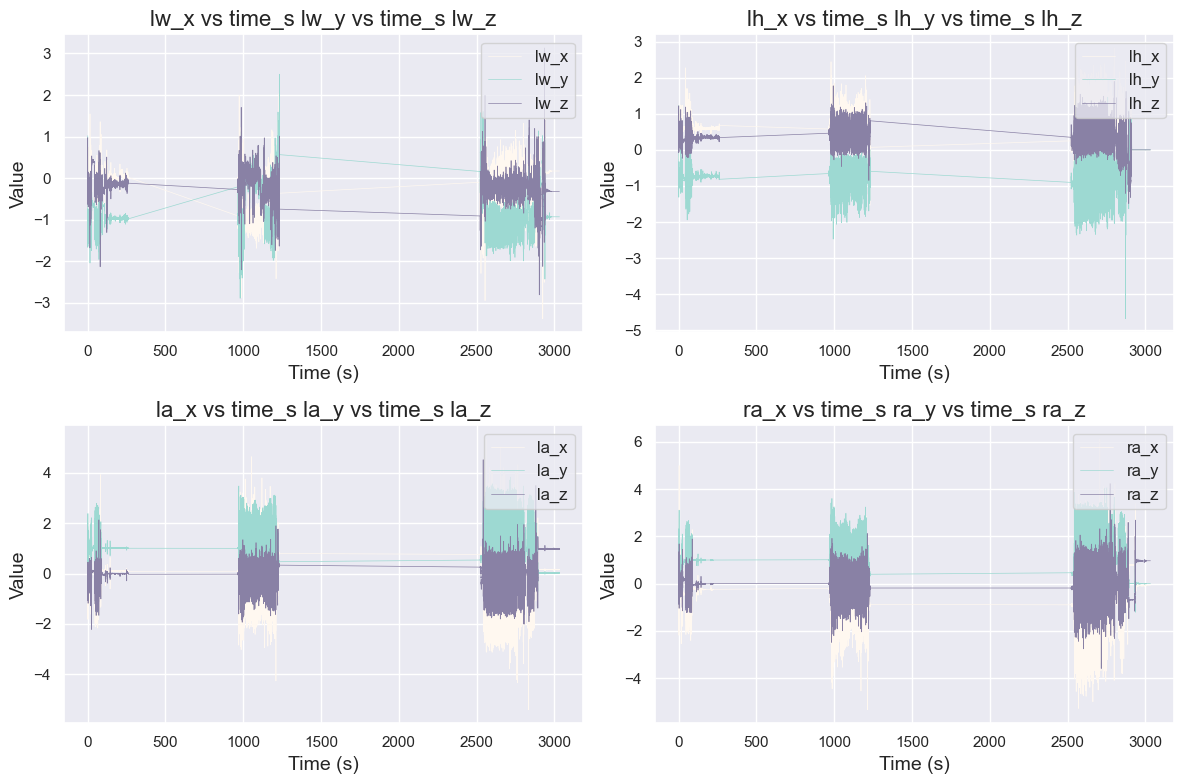

Now activity is clapping and the code is 77


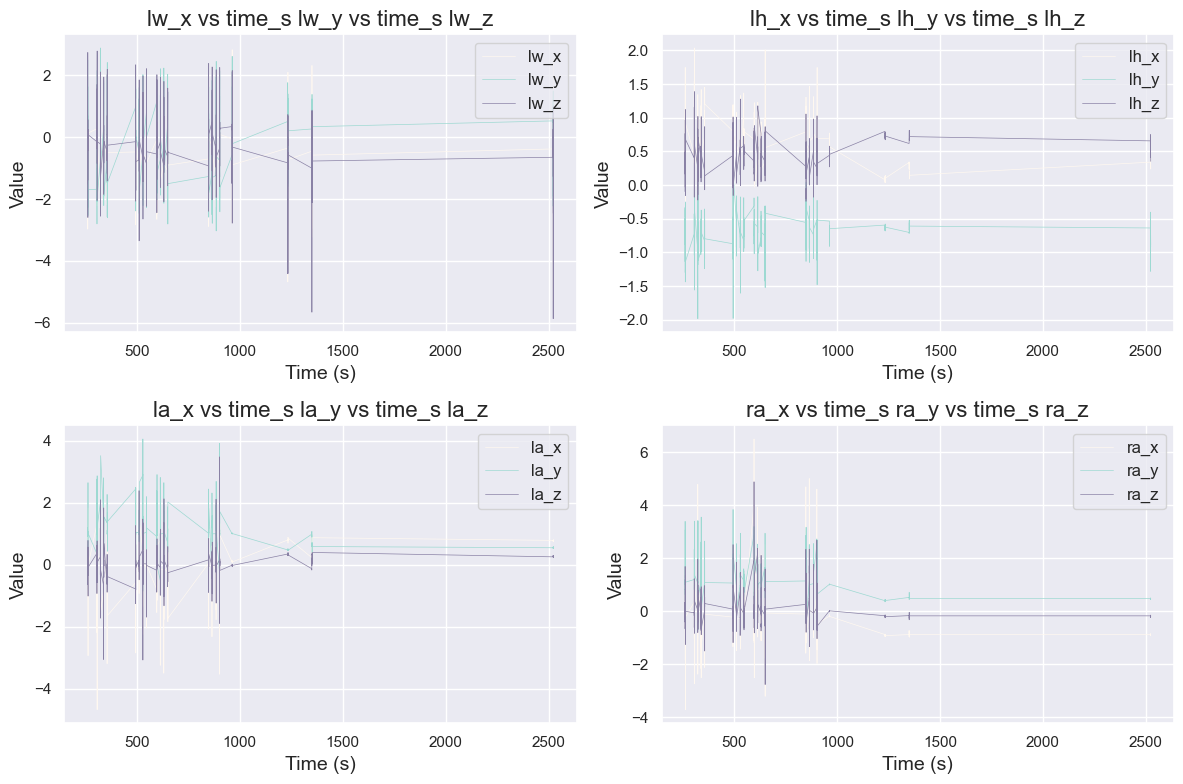

Now activity is driving and the code is 4


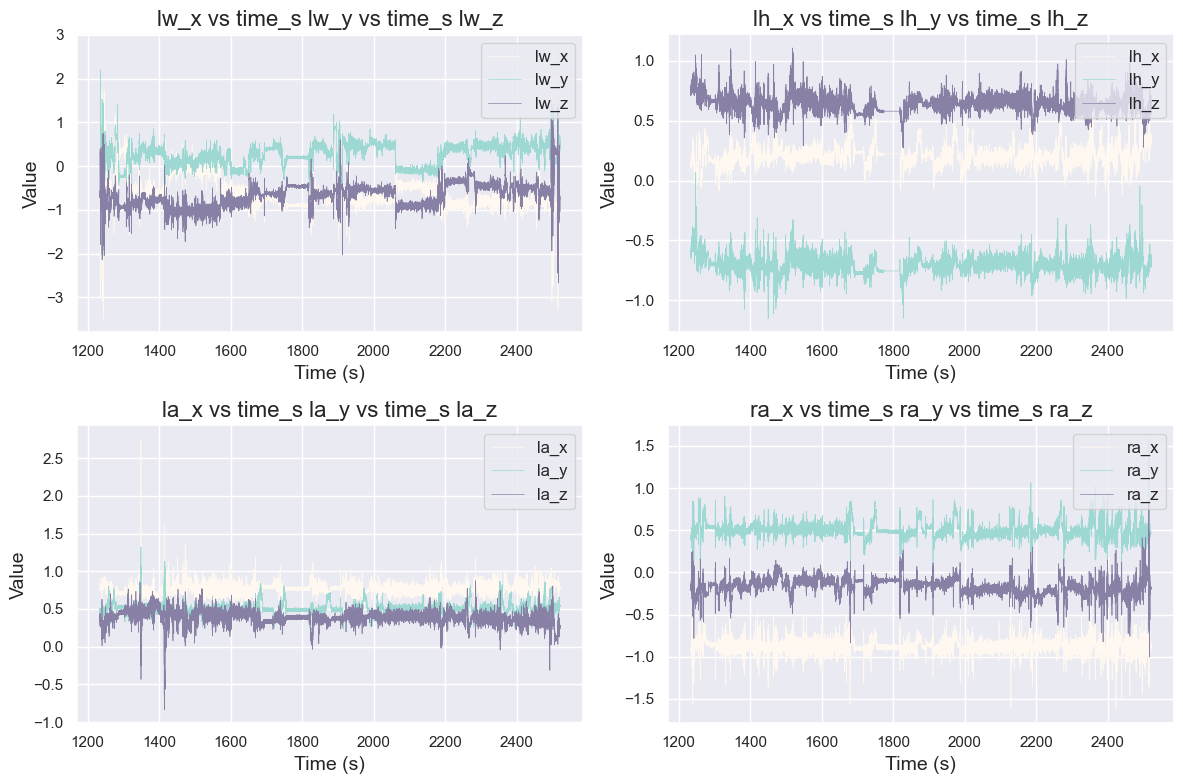

Now activity is ascending stairs and the code is 3


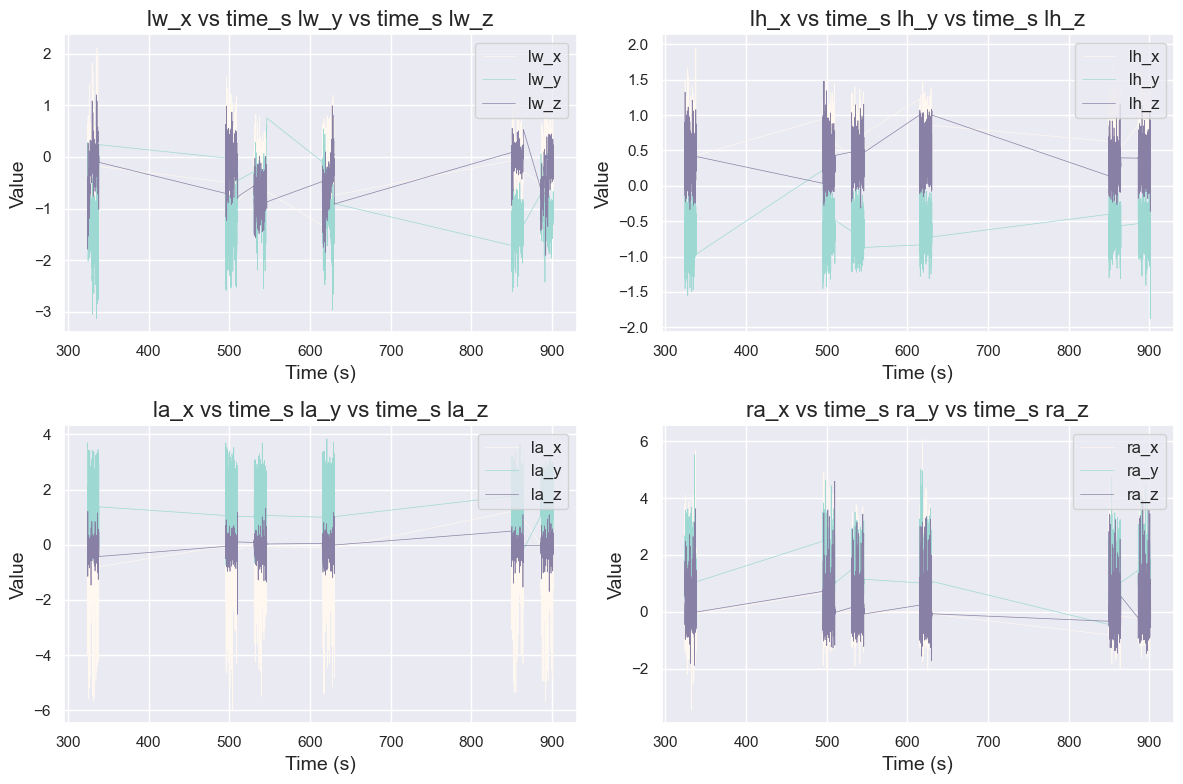

Now activity is descending stairs and the code is 2


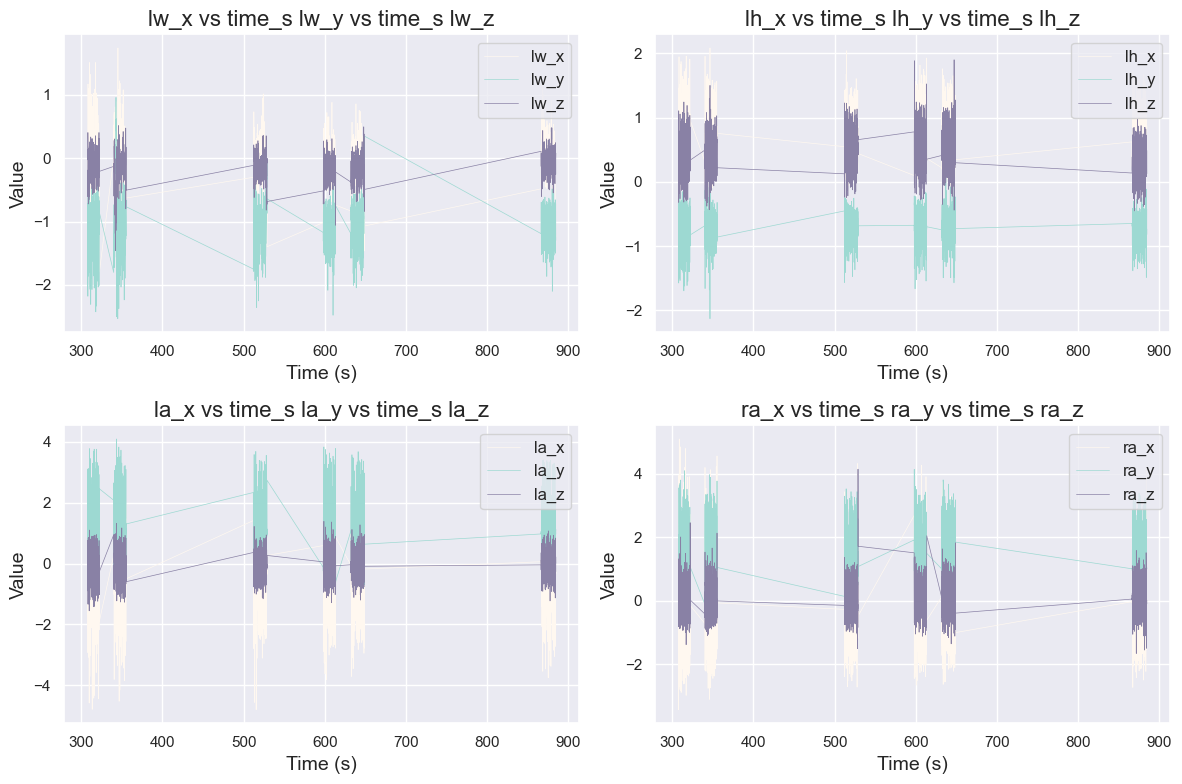

Now activity is walking and the code is 1


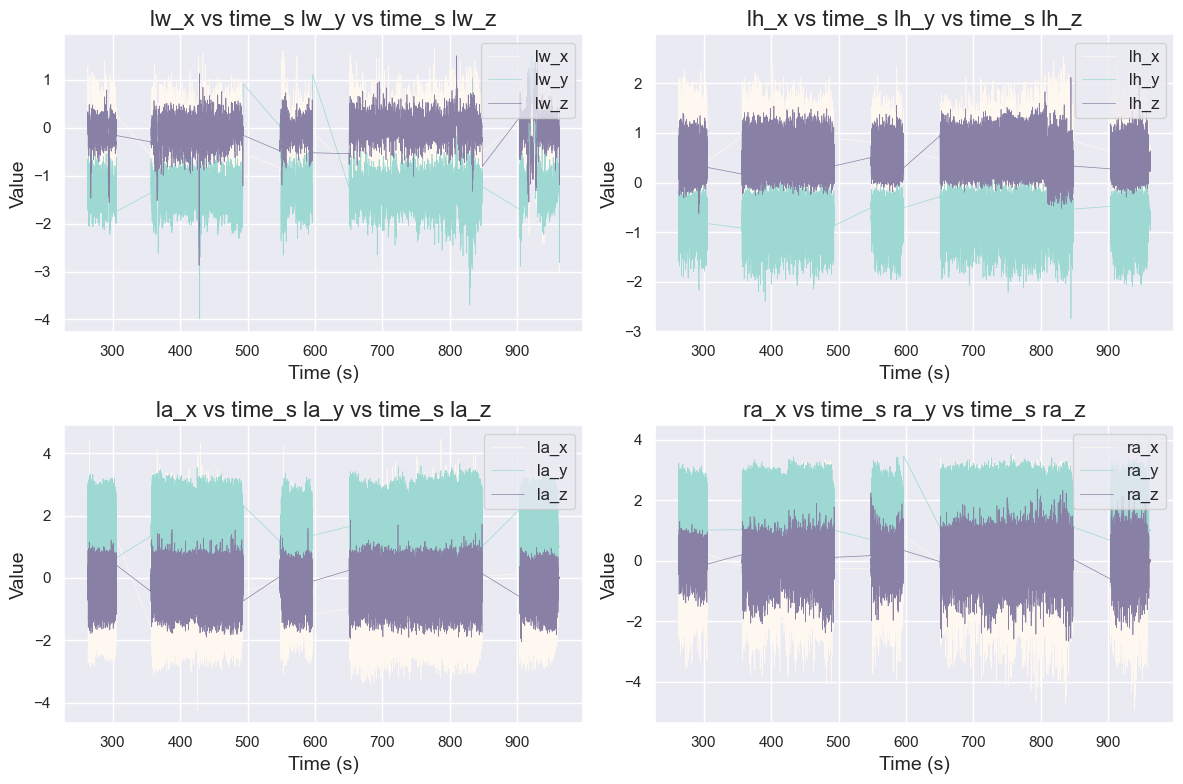

In [88]:
activity_list=[99,77,4,3,2,1]
activity_dict = {
    "non-study activity" : 99,
    "clapping" : 77,
    "driving" : 4,
    "ascending stairs" : 3,
    "descending stairs" : 2,
    "walking": 1
}


print(activity_dict.values)

for activity in activity_dict:
    print(f"Now activity is {activity} and the code is {activity_dict[activity]}")
    show_x_y_z_plot(single_df,activity_dict[activity])

In [75]:
def main():
    pass

In [76]:
if __name__ == "__main__":
    main()